# Задание, оцениваемое сокурсниками: Работа с геоданными
В этом задании вам предстоит научиться работать с географическими данными. В Питоне есть огромное количество библиотек, позволяющих эти данные обрабатывать и визуализировать; выберите ту, которая вам больше понравится. Вам может помочь руководство kaggle по работе с картами: "Семнадцать способов рисовать данные на картах". Смотрите также:

* модуль basemap (пример https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/04.13-Geographic-Data-With-Basemap.ipynb)
* плагин gmaps
* виджет ipyleaflet
* модуль folium

Поскольку мы агрегировали данные по равномерной сетке, можно ожидать, что существенное количество ячеек окажется в районах города, где вызов такси невозможен (реки, заливы, острова, парки). Теоретически ряды, соответствующие таким ячейка, должны состоять из одних нулей, но на практике это может быть не так: устройства, определяющие координаты автомобилей в момент начала поездки, несовершенны и могут ошибаться, показывая, например, что такси находится в середине реки. Чтобы правильно отобрать ячейки, вам понадобится визуализировать их границы на карте и отфильтровать те, из которых поездки на такси невозможны. 

Чтобы сдать задание, выполните следующую последовательность действий.

In [40]:
import numpy as np
import pandas as pd
import datetime
import scipy
import os
import folium
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import json
from geojson import Polygon, Feature, FeatureCollection

In [2]:
PATH_TO_DATA = 'C:/Users/Admin/Desktop/ML/6-FinalProject/Taxi'

## 1\. Загрузите агрегированные данные о поездках в мае 2016. Просуммируйте общее количество поездок такси из каждой географической зоны и посчитайте количество ячеек, из которых в мае не было совершено ни одной поездки.

In [3]:
data = pd.read_csv(os.path.join(PATH_TO_DATA, 'yellow_tripdata_2016-05_aggregated.csv'))
data.head()

,tpep_pickup_datetime,region,trips_count
0,2016-05-01 00:00:00,1,0
1,2016-05-01 00:00:00,2,0
2,2016-05-01 00:00:00,3,0
3,2016-05-01 00:00:00,4,0
4,2016-05-01 00:00:00,5,0


In [5]:
#ПК
data = pd.read_csv('yellow_tripdata_2016-05_aggregated.txt')
data = data[['tpep_pickup_datetime','region','trips_count']]
data.head()

,tpep_pickup_datetime,region,trips_count
0,2016-05-01 00:00:00,1,0
1,2016-05-01 00:00:00,2,0
2,2016-05-01 00:00:00,3,0
3,2016-05-01 00:00:00,4,0
4,2016-05-01 00:00:00,5,0


In [4]:
%matplotlib inline

In [5]:
data_grouped = data.groupby(by=["region"], as_index=False)["trips_count"].sum()
data_grouped.shape

(2500, 2)

Text(0.5, 1.0, 'Trips count per zone - may2016')

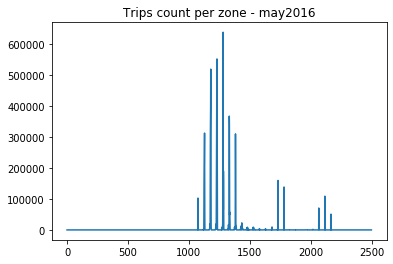

In [6]:
plt.plot(data_grouped.trips_count.values)
plt.title('Trips count per zone - may2016')

In [7]:
(data_grouped.trips_count==0).value_counts()

True     1283
False    1217
Name: trips_count, dtype: int64

In [8]:
data.shape

(1860000, 3)

**<font color='green'> Ответ на вопрос 1.** </font>*Из 1283 ячеек не было совершено ни одной поездки в мае 2016*

## 2\. Нарисуйте статическую карту Нью-Йорка. Поставьте на карте точку там, где находится Эмпайр-Стейт-Билдинг.

In [44]:
# географические координаты Empire State Building
esb_coordinates = (40.74778, -73.98583)

# географические координаты Нью-Йорка
new_york_coordinates = (40.75, -74.00)

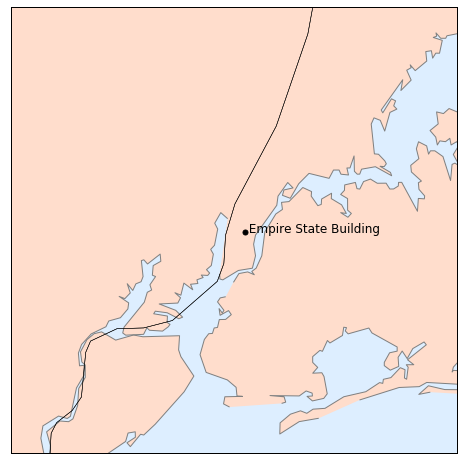

In [43]:
fig = plt.figure(figsize=(8, 16))
m = Basemap(projection='gnom', resolution='h',
            width=5e4, height=5e4, 
            lat_0=new_york_coordinates[0], lon_0=new_york_coordinates[1])

m.shadedrelief()
m.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF')
m.drawmapboundary(fill_color="#DDEEFF")
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='black')
m.drawrivers(color='blue')
# Map (long, lat) to (x, y) for plotting
x, y = m(esb_coordinates[1], esb_coordinates[0])
plt.plot(x, y, 'ok', markersize=5)
plt.text(x, y, ' Empire State Building', fontsize=12);

## 2\. Поверх статической карты Нью-Йорка визуализируйте данные о поездках из каждой ячейки так, чтобы цветовая шкала, в которую вы окрашиваете каждую ячейку, показывала суммарное количество поездок такси из неё.

In [11]:
data_regions = pd.read_csv('regions.csv', sep=';')
data_regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [12]:
data_regions['trips'] = data_grouped.trips_count.values
data_regions.head()

,region,west,east,south,north,trips
0,1,-74.25559,-74.244478,40.496120,40.504508,0
1,2,-74.25559,-74.244478,40.504508,40.512896,0
2,3,-74.25559,-74.244478,40.512896,40.521285,0
3,4,-74.25559,-74.244478,40.521285,40.529673,0
4,5,-74.25559,-74.244478,40.529673,40.538061,0


In [33]:
z = np.zeros((50,1))

for i in range(50):
    z = np.hstack((z,data_regions['trips'].iloc[i*50:(i+1)*50].to_numpy().reshape((50,1))))
z = z[:,1:]
z.shape

(50, 50)

In [13]:
meridians = data_regions['west'].append(data_regions['east']).unique()
parallels = data_regions['south'].append(data_regions['north']).unique()

C:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


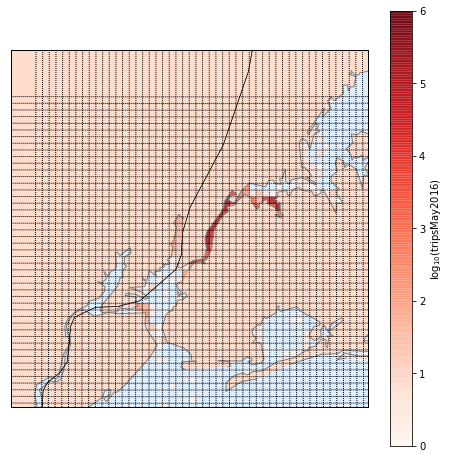

In [42]:
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='gnom', resolution='h',
            width=5e4, height=5e4, 
            lat_0=new_york_coordinates[0], lon_0=new_york_coordinates[1])

m.shadedrelief()
m.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF')
m.drawmapboundary(fill_color="#DDEEFF")
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='black')
m.drawrivers(color='blue')
m.drawparallels(parallels,labels=[False,False,False,False])
m.drawmeridians(meridians,labels=[False,False,False,False])

m.pcolormesh(meridians[1:], parallels[1:], latlon=True, data=np.log10(z), cmap='Reds', alpha=0.8, shading='flat')

plt.colorbar(label=r'$\log_{10}({\rm trips May 2016})$')
plt.clim(0, 6)

## 3\. Вставьте интерактивную карту Нью-Йорка — такую, которую можно прокручивать и увеличивать. Поставьте метку там, где находится статуя свободы

In [66]:
st_of_lib_coordinates = (40.6892494, -74.0466891)

m = folium.Map(location=new_york_coordinates, zoom_start=11, titles='New York')

folium.Marker(
    st_of_lib_coordinates,
    popup='Statue of Liberty',
    icon=folium.Icon(color='red', icon='info-sign')
).add_to(m)

m

## 5\. Нарисуйте на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны.

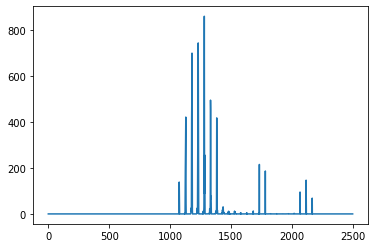

In [16]:
data_regions['trips_hourly'] = data.groupby(by=["region"], as_index=False)["trips_count"].mean()['trips_count'].values
data_regions['trips_hourly'].plot()

In [17]:
def df_to_geojson(df, lat_start='south', lat_end='north', lon_start='west', lon_end='east', reg='region'):
    my_feature_collection = []
    for _, row in df.iterrows():
        my_feature = Feature(geometry=Polygon([[(row[lon_start],row[lat_start]), (row[lon_start],row[lat_end]),
                                              (row[lon_end],row[lat_end]), (row[lon_end],row[lat_start])]]),
                             properties={"id": row[reg]})
        my_feature_collection.append(my_feature)
    return(FeatureCollection(my_feature_collection))

In [67]:
region_geo = df_to_geojson(data_regions)

m = folium.Map(location=new_york_coordinates, zoom_start=11)

folium.Choropleth(
    geo_data=region_geo,
    name='choropleth',
    data=data_regions,
    columns=['region','trips_hourly'],
    key_on='properties.id',
    fill_color='Reds',
    fill_opacity=0.5,
    line_opacity=0.1,
    legend_name='Mean trips count per hour',
    reset=True
).add_to(m)

folium.LayerControl().add_to(m)

m

## 6\. Чтобы не выбирать из всех 2500 ячеек вручную, отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитайте количество оставшихся. Проверьте на карте, что среди этих ячеек нет таких, из которых поездки на самом деле невозможны.

In [65]:
(data_regions['trips_hourly']>=5).value_counts()

False    2398
True      102
Name: trips_hourly, dtype: int64

**<font color='green'> Ответ на вопрос 6.** </font>*Из 102 ячеек было совершено в среднем не менее 5 поездок в час в мае 2016. По результатам визуализации отфильтрованного списка ячеек можно сделать вывод об отсутствии аномальных данных (ячеек, из которых поездки не возможны в реальности)*

In [68]:
data_regions['over5trips_hourly'] = data_regions['trips_hourly']
X = data_regions['over5trips_hourly'].to_numpy()
X[X < 5] = 0
data_regions['over5trips_hourly'] = X

m = folium.Map(location=new_york_coordinates, zoom_start=11)

folium.Choropleth(
    geo_data=region_geo,
    name='choropleth',
    data=data_regions,
    columns=['region','over5trips_hourly'],
    key_on='properties.id',
    fill_color='Reds',
    fill_opacity=0.5,
    line_opacity=0.1,
    legend_name='Over 5 trips count per hour',
    reset=True
).add_to(m)

m

## 7\. Сохраните ноутбук в формате html, запакуйте ipynb и html в один архив и загрузите его в форму (html облегчит задачу проверки вашим рецензентам — в ipynb динамические карты часто не сохраняются, а для выполнения кода рецензентам придётся устанавливать все библиотеки). 